In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch.optim as optim
import torch.nn as nn
import cv2
import json
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cpu


In [11]:
def read_batch(data, index):
    with open(data[index], 'r') as f:
        json_obj = json.load(f)
    image = cv2.imread(json_obj['image'])
    mask = np.load(json_obj['map'])
    return image, mask

images_dir = 'C:/Users/tjker/Desktop/School/Graduate/Spring_2025/Rapids/ml_intro/initial_images'
data = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(('.json'))]

In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)

optimizer = optim.Adam(params=predictor.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss() 

In [ ]:
img, mask = read_batch(data, 1)

input_point = np.empty((0, 2))
input_label = np.empty((0,), dtype=int)

predictor.set_image(img)
pred_masks, scores, logits = predictor.predict(
    point_coords = input_point,
    point_labels = input_label,
    multimask_output = False
)

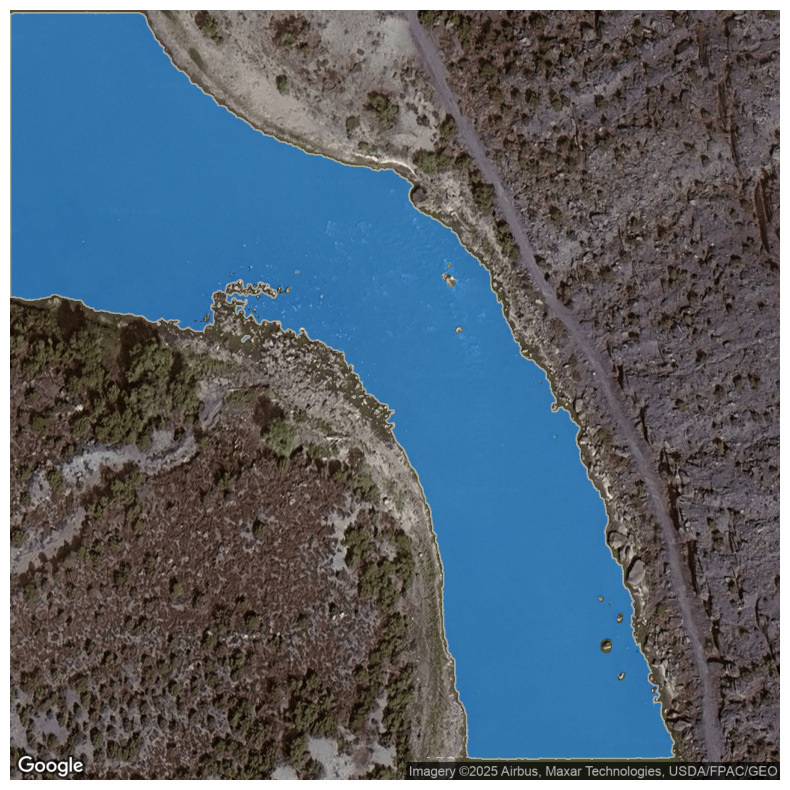

In [18]:
from helper_functions import show_masks
show_masks(img, pred_masks, scores, borders=True)

In [ ]:
input_point = np.empty((0, 2)) 
input_label = np.empty((0,), dtype=int) 

num_epochs = 10
for epoch in range(num_epochs):
    sam2_model.train()
    for i in range(len(data)):
        img, mask = read_batch(data, i)
        optimizer.zero_grad()
        predictor.set_image(img)
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)

        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
        )
        
        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
            repeat_image=batched_mode,
            high_res_features=high_res_features,
        )

        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

        gt_mask = torch.tensor(mask.astype(np.float32)).to(device)
        prd_mask = torch.sigmoid(prd_masks[:, 0])
        seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss = seg_loss + score_loss * 0.05

        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}")

Epoch 0, Iteration 0, Loss: 1.3088016510009766
Epoch 1, Iteration 0, Loss: 0.1273370236158371
Epoch 2, Iteration 0, Loss: 0.06694235652685165
Epoch 3, Iteration 0, Loss: 0.044732820242643356
Epoch 4, Iteration 0, Loss: 0.03502412140369415
Epoch 5, Iteration 0, Loss: 0.02708677388727665
Epoch 6, Iteration 0, Loss: 0.020626479759812355
Epoch 7, Iteration 0, Loss: 0.01601138710975647
Epoch 8, Iteration 0, Loss: 0.013016053475439548
Epoch 9, Iteration 0, Loss: 0.011547881178557873


In [ ]:
torch.save(sam2_model.state_dict(), f"sam2_model_finetuned_epoch_{epoch + 1}.pt")